# Amazon Reviews Modelling Using BERT with Noisy Labels

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
!pip install --upgrade pyarrow

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pd.options.display.max_rows = None
seed=40

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Amazon Reviews Dataset

### taking 10% of the data to analyze and to be trained.

In [4]:
rn.seed(a=40)

review = pd.read_csv('../input/amazon-product-reviews/Reviews.csv')
review.shape

(568454, 10)

In [5]:
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### grouping the scores into positive and negative sentiment

In [6]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0
    
review['review_score']= review.Score.apply(score_round)
          
review = review.rename(columns={'Text':'review_text'})
df=review.copy()

In [7]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [8]:
zeroes=df[review['review_score']==0].head(30000)
ones=df[review['review_score']==1].head(20000)

In [9]:
d=pd.concat([zeroes,ones])

In [10]:
d.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,review_text,review_score
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,0
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0


In [11]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [12]:
df=d.copy()
df=df.sample(frac=1).reset_index(drop=True)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,review_text,review_score
0,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0
1,16026,B00149ZSD0,AEK402C2091V4,Patsy,0,0,5,1310256000,I Love the Turtles they were so good.,I love the Turtles. They were not melted. Than...,1
2,3870,B001M074MY,A115TANMJQBF1Z,"Wheeler17 ""Bethany""",0,0,5,1319932800,Great alternative for K-cup users,Melitta Pods are an inexpensive alternative to...,1
3,19703,B0030VBRIU,A3P9MK4EKMA892,PeruMom,0,0,1,1306800000,Yuck!,I (and my little guy) have loved almost all ot...,0
4,17982,B008ZRKZSM,A1J020XG7TABPG,"Jo E. Meyertons ""Creative Mind""",1,1,4,1314403200,"Like shirataki noodles, this is a winner",Based in part on the helpful reviews I found h...,1


In [13]:
d=df.copy()

In [14]:
d['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [15]:
df['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [16]:
review=df.copy()

### making sure that text review data type is string

In [17]:
review.review_text = review.review_text.astype('str')
review.Summary = review.Summary.astype('str')

# 3.  Distribution of Reviews in Each Sentiment

### the visualization of it.

In [18]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

# 4. Data Cleaning For Sentiment Processing

In [19]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Null values Cleaning

In [20]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

### Duplicate Values Removing

In [21]:
review = review.drop_duplicates(keep='first')

In [22]:
review.shape

(50000, 11)

### a function to clean some basic characters

In [23]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### function to remove numbers

In [24]:
def remove_num(texts):
    output = re.sub(r'\d+', '', texts)
    return output

### function to remove emoji

In [25]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### function to unify whitespaces

In [26]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### function to remove symbols

In [27]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### function to remove punctuation

In [28]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### function to remove stopwords

In [29]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
    text=[word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

### function to use stemming to normalize words

In [30]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
    stem=[]
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    stem=' '.join(stemmed_word)
    return stem

### combining all the cleaning functions

In [31]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [32]:
cleaning(review,'review_text')

### Now all the cleanings are done and will try to visualize the common words distribution of our review texts.

### common words are 'br','like','taste'

# 5. BERT Tokenizing and Modelling

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()


### Split Data to Training, Validation, and Hold-Out Data

In [34]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [35]:
# split the dataset into train, validation and holdout sets (60-20-20)
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)
validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [36]:
training_labels = pd.Series(training_labels)

In [37]:
#print(training_sentences[23293])
#print(training_labels[23293])

In [38]:
num_rows_to_shuffle = int(0.5 * len(training_labels))
np.random.seed(0)  
indices_to_shuffle = np.random.choice(training_labels.index[1:], size=num_rows_to_shuffle, replace=False)
training_labels.iloc[indices_to_shuffle] = 1 - training_labels.iloc[indices_to_shuffle] #Single flip

In [39]:
print(indices_to_shuffle)

[18711 23293 28849 ... 10146  3715  5863]


In [40]:
#print(training_sentences[23293])
#print(training_labels[23293])

### Tokenize Input Data

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

In [42]:
# Example of the tokenizer output
tokenized_output = tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

In [43]:
review['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [44]:
training_labels = training_labels.tolist()

In [45]:
# tokenize training, validation and hold-out Texts

train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [46]:

train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

In [47]:
print(type(training_labels))
print(type(validation_labels))
print(type(holdout_labels))

<class 'list'>
<class 'list'>
<class 'list'>


### BERT Model Fine-Tuning

In [48]:
import json

class SaveResultsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(f'results_epoch_{epoch}.json', 'w') as f:
            json.dump(logs, f)

In [49]:
# initialize pre-trained BERT model

model = TFBertForSequenceClassification.from_pretrained('bert-large-cased',num_labels=2)

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [51]:
history = model.fit(train_dataset.shuffle(1000).batch(2),
          epochs=1,
          validation_data=validation_dataset.shuffle(1000).batch(2),
                verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


15000/15000 [==============================] - 13161s 875ms/step - loss: 0.7056 - accuracy: 0.4992 - val_loss: 0.7264 - val_accuracy: 0.4040


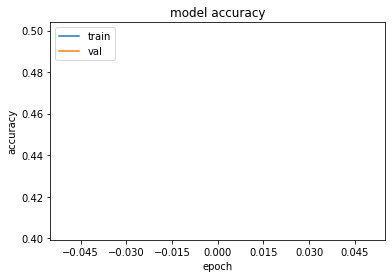

In [52]:
from matplotlib.ticker import MaxNLocator

# plot train and validation accuracy

ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
model.save_pretrained("./output_model")

### BERT Model's Performance Evaluation

In [54]:
'''from transformers import TFBertForSequenceClassification, BertTokenizer

# Load the model
loaded_model = TFBertForSequenceClassification.from_pretrained("./bert_large_cased_model")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("./bert_large_cased_model")'''

'from transformers import TFBertForSequenceClassification, BertTokenizer\n\n# Load the model\nloaded_model = TFBertForSequenceClassification.from_pretrained("./bert_large_cased_model")\n\n# Load the tokenizer\ntokenizer = BertTokenizer.from_pretrained("./bert_large_cased_model")'

In [55]:
# load the model and then evaluate it on holdout set

loaded_model = TFBertForSequenceClassification.from_pretrained("./output_model")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

1250/1250 [==============================] - 1233s 987ms/step - loss: 0.7272 - accuracy: 0.4009


{'loss': 0.7271579504013062, 'accuracy': 0.4009000062942505}

### the model's accuracy 88.94% on the holdout set (other validation set)

In [56]:
# predict the sentiment for holdout set
tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

In [57]:
# confusion matrix of our predictions

cm = tf.math.confusion_matrix(
    holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()

print("confusion matrix\n",cm)

confusion matrix
 [[   0 5991]
 [   0 4009]]


### The model has a strong ability to correctly identify positive instances, with relatively few errors in misclassifying positives as negatives and vice versa. The high number of true positives and true negatives compared to false positives and false negatives indicates good performance in both detecting positives and rejecting negatives.

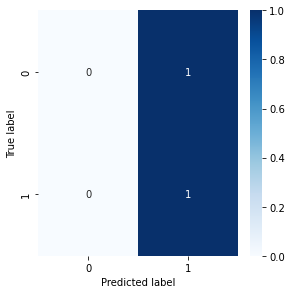

In [58]:
# visualize the confusion matrix

cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm,
                 index = [0,1], 
                 columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [59]:
# Precision, Recall, and F1-Score

tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)
f1score = (2*precision*recall) / (precision + recall)

print("recall score:", recall)
print("precision score:", precision)
print("F1-Score:",f1score)

recall score: 0.0
precision score: nan
F1-Score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in int_scalars
  # Remove the CWD from sys.path while we load stuff.


### The model's score with f1-score of 0.909.That's a strong F1-score, indicating the model performs well in terms of precision and recall. 